# Analyze TCC trends with Predicted Heights for Boreal Height CMIP6 work
join recent trend with predicted heights

In [1]:
import os
import glob
import pandas as pd
import geopandas as gpd
import contextily as ctx
import plotnine
from plotnine import *
import numpy as np

/tmp/ipykernel_1391145/184143578.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# Recent trends
Read back in and examine zonal stats GDF

In [2]:
zonal_basins_gdf = gpd.read_file('/home/pmontesa/mfrost2/projects/boreal_hcan/data/hydrobasins_L08_patterns_tte_boreal_tundra_tcc_trends.gpkg')

In [3]:
p_val_crit = 0.1

In [4]:
# Fix col types
float_cols = zonal_basins_gdf.filter(like='val_', axis=1).columns
zonal_basins_gdf[float_cols] = zonal_basins_gdf[float_cols].apply(pd.to_numeric)

#### Summarize basins with pvalue sig level and dropna 
basins with na for recent trends were outside of the domain for which trends were calc'd

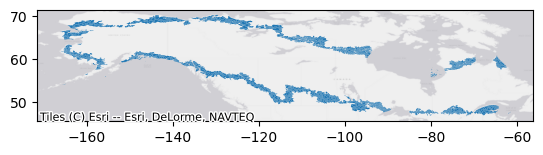

In [5]:
%matplotlib inline
ax = zonal_basins_gdf[pd.isnull(zonal_basins_gdf).any(axis=1)].plot()
ax = ctx.add_basemap(ax=ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas)

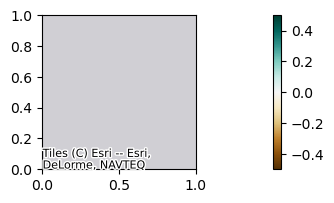

In [6]:
ax = zonal_basins_gdf[pd.isnull(zonal_basins_gdf).any(axis=1)].to_crs(4326).plot(column='val_terrapulse_tcc_slope_median', cmap='BrBG', legend=True, vmin=-0.5, vmax=0.5, figsize=(20,2))
ax = ctx.add_basemap(ax=ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas)

In [7]:
# Calc proportion of basins with pvals below critical level
sig_col_name = 'Significance level'
condition_1 = zonal_basins_gdf['val_terrapulse_tcc_pvalue_median'].lt(p_val_crit)
zonal_basins_gdf[sig_col_name] = np.where(condition_1, f'p<{p_val_crit}',f'p>={p_val_crit}')

# Dropna here 
z_smry = zonal_basins_gdf.dropna().groupby([sig_col_name, 'pattern_class']).aggregate(count_class=('pattern_class', 'count')).reset_index()
z_smry

,Significance level,pattern_class,count_class
0,p<0.1,Boreal Forest (taiga),4406
1,p<0.1,Non-forest (tundra),5
2,p<0.1,TTE (abrupt edge),39
3,p<0.1,TTE (abrupt),191
4,p<0.1,TTE (diffuse),4056
5,p<0.1,TTE (uniform),254
6,p>=0.1,Boreal Forest (taiga),2346
7,p>=0.1,TTE (abrupt edge),233
8,p>=0.1,TTE (abrupt),330
9,p>=0.1,TTE (diffuse),826


#### Significance of Landsat TCC trend
This summarizes by forest structure pattern class the proportion of landscapes whose median pvalue is less than 0.1. Most landscapes have median values less than this threshold, suggesting a preponderance of significant trends at mesoscales.

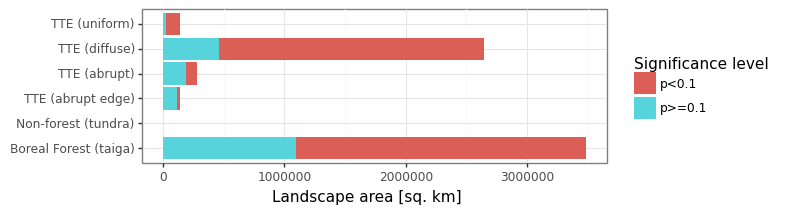

In [8]:
plot_pvalue_bars = (
    ggplot(zonal_basins_gdf.dropna())
    + geom_bar(aes(x='pattern_class', y='area_sqkm', fill=sig_col_name), stat='identity')
    + theme_bw()
    + theme(figure_size=(6,2))
    + labs(x='', y='Landscape area [sq. km]')
    + coord_flip()
)
print(plot_pvalue_bars)

In [10]:
plot_pvalue_bars.save('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/boreal_height_cmip/plots/S5_plot_pvalue_tcc_trend.png', dpi=300) 

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2 in image.
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /explore/nobackup/people/pmontesa/userfs02/projects/ilab/boreal_height_cmip/plots/S5_plot_pvalue_tcc_trend.png


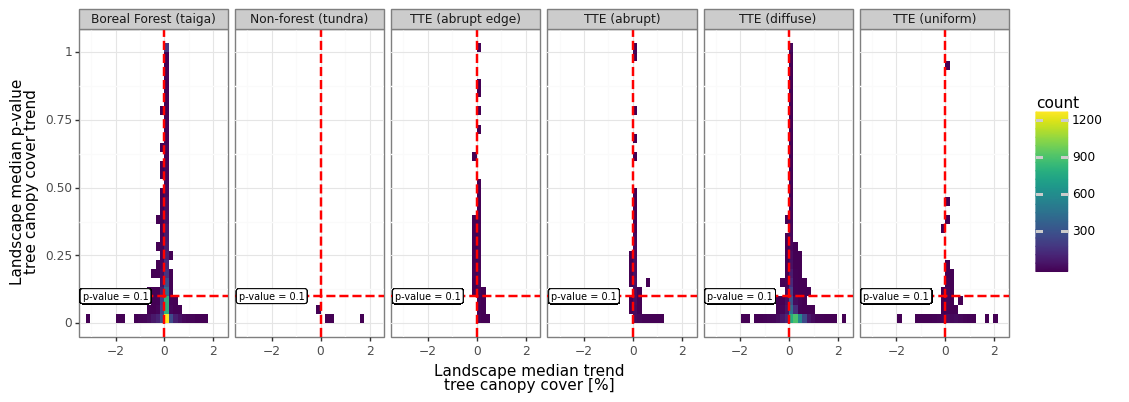

<ggplot: (1429741660516)>

In [79]:
(
  ggplot(data = zonal_basins_gdf.dropna()) 
    + geom_bin2d(mapping=aes(x='val_terrapulse_tcc_slope_median', y='val_terrapulse_tcc_pvalue_median'))
    + geom_vline(xintercept=0, linetype='dashed', color='red', size=1.0)
    + geom_hline(yintercept=p_val_crit, linetype='dashed', color='red', size=1.0)
    + geom_label(x=-2, y=p_val_crit, label=f'p-value = {p_val_crit}', size=7)
    #+ geom_hline(yintercept=0.01, linetype='dashed', color='red', size=1.5)

    #+ geom_point(mapping=aes(x='val_terrapulse_tcc_slope_median', y='val_terrapulse_tcc_pvalue_median'), alpha=0.1)
    + theme_bw()
    + labs(x = 'Landscape median trend\ntree canopy cover [%]',
           y = 'Landscape median p-value\ntree canopy cover trend'
          )
    + facet_wrap('~pattern_class', ncol=6)
    + theme(figure_size=(12,4))

)

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_boxplot : Removed 2583 rows containing non-finite values.


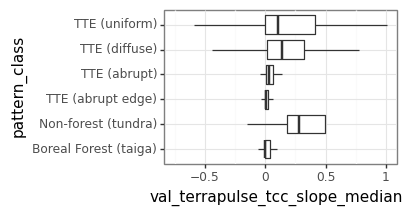

<ggplot: (1429763797601)>

In [80]:
#zonal_basins_gdf["val_terrapulse_tcc_slope_median"] = zonal_basins_gdf.val_terrapulse_tcc_slope_median.astype(float)
(
    ggplot(zonal_basins_gdf)
    + geom_boxplot(aes(x='pattern_class', y='val_terrapulse_tcc_slope_median', fill='val_terrapulse_tcc_slope_count'), outlier_shape = '')
    + theme_bw()
    + theme(figure_size=(9,3))
    + coord_cartesian(ylim=(-0.75,1))
    + coord_flip(ylim=(-0.75,1))
    + theme(figure_size=(3,2))
)

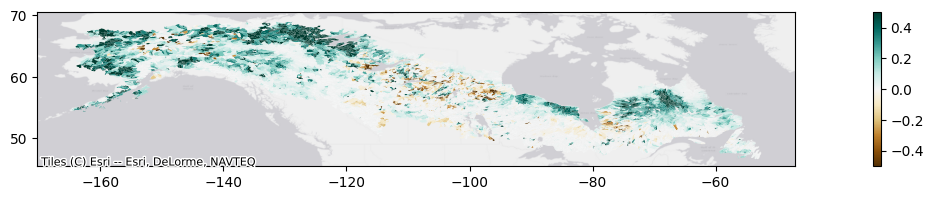

In [91]:
ax = zonal_basins_gdf.to_crs(4326).plot(column='val_terrapulse_tcc_slope_median', cmap='BrBG', legend=True, vmin=-0.5, vmax=0.5, figsize=(20,2))
ax = ctx.add_basemap(ax=ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas)

# Future predictions (height) diffs from current predictions (height)

In [77]:
zonal_basins_DIFFS_gpd = gpd.read_file('/explore/nobackup/people/mfrost2/projects/boreal_hcan/GIS/hydrobasins_L08_patterns_tte_boreal_tundra_median_diffs.gpkg')

In [81]:
zonal_basins_DIFFS_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17052 entries, 0 to 17051
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   HYBAS_ID                   17052 non-null  int64   
 1   pattern_class              17052 non-null  object  
 2   Med_diff_ssp245_2061-2080  16559 non-null  float64 
 3   Med_diff_ssp585_2041-2060  16559 non-null  float64 
 4   Med_diff_ssp585_2061-2080  16559 non-null  float64 
 5   Med_diff_ssp126_2061-2080  16559 non-null  float64 
 6   Med_diff_ssp245_2041-2060  16559 non-null  float64 
 7   Med_diff_ssp370_2041-2060  16559 non-null  float64 
 8   Med_diff_ssp370_2081-2100  16559 non-null  float64 
 9   Med_diff_ssp370_2021-2040  16559 non-null  float64 
 10  Med_diff_ssp585_2021-2040  16559 non-null  float64 
 11  Med_diff_ssp370_2061-2080  16559 non-null  float64 
 12  Med_diff_ssp585_2081-2100  16559 non-null  float64 
 13  Med_diff_ssp126_2021-20

In [ ]:
%matplotlib inline
# Landscapes with nodata for Median Diffs are either smaller than the predictions or at the edge of the domain, it seems
ax = zonal_basins_DIFFS_gpd[pd.isnull(zonal_basins_DIFFS_gpd['Med_diff_ssp585_2081-2100'])].plot()
ax = ctx.add_basemap(ax=ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas)

In [83]:
zonal_basins_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15317 entries, 0 to 15316
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   level_0                                  15317 non-null  int64   
 1   index                                    15317 non-null  int64   
 2   HYBAS_ID                                 15317 non-null  int64   
 3   pattern_class                            15317 non-null  object  
 4   val_terrapulse_tcc_slope_max             12734 non-null  float64 
 5   val_terrapulse_tcc_slope_min             12734 non-null  float64 
 6   val_terrapulse_tcc_slope_median          12734 non-null  float64 
 7   val_terrapulse_tcc_slope_mean            12734 non-null  float64 
 8   val_terrapulse_tcc_slope_percentile_02   12734 non-null  float64 
 9   val_terrapulse_tcc_slope_percentile_25   12734 non-null  float64 
 10  val_terrapulse_tcc_slope_p

# Join: recent trends with future predictions

In [102]:
med_diff_cols = zonal_basins_DIFFS_gpd.filter(like='Med_diff', axis=1).columns.to_list()

In [103]:
joined = pd.merge(zonal_basins_gdf.dropna(), zonal_basins_DIFFS_gpd[med_diff_cols+['HYBAS_ID']].dropna(), how = 'left', on = 'HYBAS_ID')

In [104]:
joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 12734 entries, 0 to 12733
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   level_0                                  12734 non-null  int64   
 1   index                                    12734 non-null  int64   
 2   HYBAS_ID                                 12734 non-null  int64   
 3   pattern_class                            12734 non-null  object  
 4   val_terrapulse_tcc_slope_max             12734 non-null  float64 
 5   val_terrapulse_tcc_slope_min             12734 non-null  float64 
 6   val_terrapulse_tcc_slope_median          12734 non-null  float64 
 7   val_terrapulse_tcc_slope_mean            12734 non-null  float64 
 8   val_terrapulse_tcc_slope_percentile_02   12734 non-null  float64 
 9   val_terrapulse_tcc_slope_percentile_25   12734 non-null  float64 
 10  val_terrapulse_tcc_slope_p

In [109]:
g = joined.groupby('pattern_class')
pattern_class_list = list(g.groups.keys())
pattern_class_list

['Boreal Forest (taiga)',
 'Non-forest (tundra)',
 'TTE (abrupt edge)',
 'TTE (abrupt)',
 'TTE (diffuse)',
 'TTE (uniform)']

In [142]:
joined.pattern_class = pd.Categorical(joined.pattern_class, categories=['Non-forest (tundra)','TTE (abrupt edge)','TTE (abrupt)','TTE (diffuse)','TTE (uniform)','Boreal Forest (taiga)'])
joined=joined.sort_values('pattern_class').dropna()
joined.shape

(12422, 41)

In [160]:
joinedm = pd.melt(joined, 
                       id_vars=['HYBAS_ID','pattern_class','val_terrapulse_tcc_slope_median', 'val_terrapulse_tcc_pvalue_median',sig_col_name,'area_sqkm'], 
                       value_vars=med_diff_cols
                      )
joinedm[['stat', 'type', 'ssp', 'time_period']] = joinedm['variable'].str.split('_',expand=True)
joinedm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198752 entries, 0 to 198751
Data columns (total 12 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   HYBAS_ID                          198752 non-null  int64   
 1   pattern_class                     198752 non-null  category
 2   val_terrapulse_tcc_slope_median   198752 non-null  float64 
 3   val_terrapulse_tcc_pvalue_median  198752 non-null  float64 
 4   Significance level                198752 non-null  object  
 5   area_sqkm                         198752 non-null  float64 
 6   variable                          198752 non-null  object  
 7   value                             198752 non-null  float64 
 8   stat                              198752 non-null  object  
 9   type                              198752 non-null  object  
 10  ssp                               198752 non-null  object  
 11  time_period                       19875

In [162]:
condition_1 = joinedm['val_terrapulse_tcc_slope_median'].lt(0)
condition_2 = joinedm['val_terrapulse_tcc_slope_median'].eq(0)
condition_3 = joinedm['val_terrapulse_tcc_slope_median'].gt(0)

condition_a = joinedm['value'].lt(0)
condition_b = joinedm['value'].eq(0)
condition_c = joinedm['value'].gt(0)

joinedm['change_class_tcc'] = np.where(condition_1, '-1', np.where(condition_2, '0', np.where(condition_3, '+', '?')))
joinedm['change_class_height'] = np.where(condition_a, '-1', np.where(condition_b, '0', np.where(condition_c, '+', np.nan)))
joinedm.head()

,HYBAS_ID,pattern_class,val_terrapulse_tcc_slope_median,val_terrapulse_tcc_pvalue_median,Significance level,area_sqkm,variable,value,stat,type,ssp,time_period,change_class_tcc,change_class_height
0,8080153510,Non-forest (tundra),1.691925,5.257092e-08,p<0.1,215.971658,Med_diff_ssp245_2061-2080,-1.196483,Med,diff,ssp245,2061-2080,+,-1
1,8080140780,Non-forest (tundra),-0.150601,6.607120e-02,p<0.1,40.949709,Med_diff_ssp245_2061-2080,-2.144581,Med,diff,ssp245,2061-2080,-1,-1
2,7080115501,TTE (abrupt edge),0.021810,1.655761e-01,p>=0.1,72.677073,Med_diff_ssp245_2061-2080,4.299854,Med,diff,ssp245,2061-2080,+,+
3,7080114802,TTE (abrupt edge),0.014771,3.210491e-01,p>=0.1,678.618400,Med_diff_ssp245_2061-2080,3.801277,Med,diff,ssp245,2061-2080,+,+
4,7080114692,TTE (abrupt edge),0.018492,2.950151e-01,p>=0.1,150.624854,Med_diff_ssp245_2061-2080,4.299854,Med,diff,ssp245,2061-2080,+,+


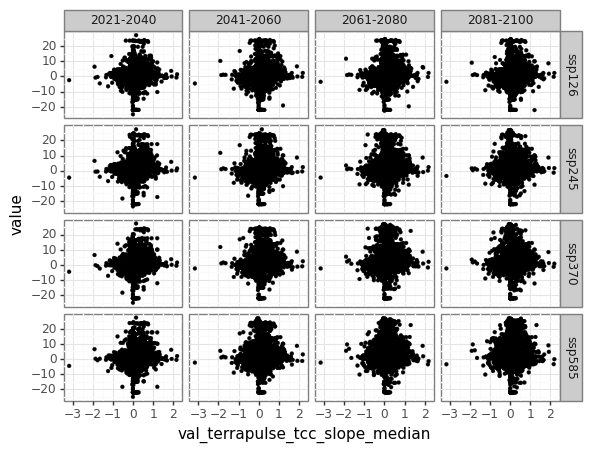

<ggplot: (1429688043325)>

In [171]:
(
    ggplot(joinedm)
    + geom_point(aes(x='val_terrapulse_tcc_slope_median', y='value'), stroke=0.1, shape='o')
    + facet_grid('ssp~time_period')
    + theme_bw()
)

In [87]:
# Save joined gdf
fn = '/home/pmontesa/mfrost2/projects/boreal_hcan/data/hydrobasins_L08_patterns_tte_boreal_tundra_joined_future_recent.gpkg'